## 导入库

In [8]:
import torch
import pandas as pd
import os
import numpy as np

## 模型训练

### 导入数据

In [9]:
# 获取当前文件所在目录的绝对路径
current_directory = os.getcwd()
# 拼接文件夹路径
folder_path = os.path.join(current_directory, "..", "data")
# 拼接文件路径
data = np.load(os.path.join(folder_path, "lane_change_data.npz"))
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

### 模型训练+参数优化

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

# a矩阵存储的是不同参数对应的 训练得分
# b矩阵存储的是不同参数对应的 测试得分

import numpy as np
import xgboost as xgb

re_optimal_parameter = False
if re_optimal_parameter:
    a = np.zeros([6, 6])
    b = np.zeros([6, 6])
    for i in range(6):
        max_depth_i = (i + 1) * 10
        for j in range(6):
            n_estimators_j = (j + 1) * 10
            other_params = {'learning_rate': 0.1, 'n_estimators': n_estimators_j, 'max_depth': max_depth_i,
                            'min_child_weight': 0.2, 'seed': 0,
                            'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_alpha': 0, 'reg_lambda': 0.5}
            model = xgb.XGBClassifier(**other_params)
            model.fit(x_train,
                      y_train)
            y_hat = model.predict(x_test)
            y_hat_train = model.predict(x_train)
            Xgbc_score_a = accuracy_score(y_test, y_hat)
            Xgbc_score_b = accuracy_score(y_train, y_hat_train)
            a[i][j] = Xgbc_score_a
            b[i][j] = Xgbc_score_b
            print('max_depth {}  +  n_estimators {}  = {}'.format(max_depth_i, n_estimators_j, Xgbc_score_a))

In [11]:
other_params = {'learning_rate': 0.1, 'n_estimators': 60, 'max_depth': 10, 'min_child_weight': 0.2, 'seed': 0,
                'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.01, 'reg_alpha': 0, 'reg_lambda': 0.5}
model = xgb.XGBClassifier(**other_params)
model.fit(x_train,
          y_train)
y_hat = model.predict(x_test)
Xgbc_score_a = accuracy_score(y_test, y_hat)
Xgbc_score_a

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:52:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9788888888888889

### EIDG 归因值计算

In [12]:
from EIDG import EIDG
# from EIDG1 import EIDG
def model_modity(input):
    return model.predict_proba(input)[:,0]
eidg_instance = EIDG(x_baselines=x_test, model = model.predict_proba ,steps=150, h=0.1, m=10, pos=True)
explainer_xgb_eidg_values = eidg_instance.integrated_gradients(x_test)

EIDG运行时间： 2.4263603687286377 秒


##测试modified模型的shapley值+基值 是否等于输出值，不关系主要程序

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%config InlineBackend.figure_format = 'svg'
plt.style.use('default')  # 设置画图的风格
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import numpy as np
# 数据
feature_name = ['$v_0$', '$v_1$', '$v_2$', '$v_3$', '$d_1$', '$d_2$', '$d_3$']

#### 找到

sample number: 0 
  feature value: [30.96 28.92 38.05 40.28 17.31 66.45 29.97] 
 EIDG value: [-0.00260247  0.00304165 -0.0832583  -0.6179482   0.00201669  0.13704836
  0.05210492]


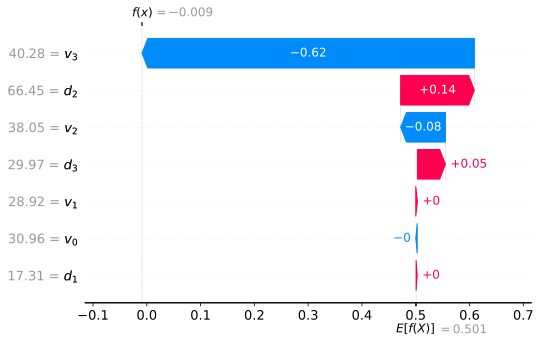

sample number: 1 
  feature value: [30.73 24.84 34.4  31.02 34.09 50.25 15.48] 
 EIDG value: [ 0.03448159  0.0198667   0.14840113  0.09206864 -0.02522751  0.13806306
  0.03014631]


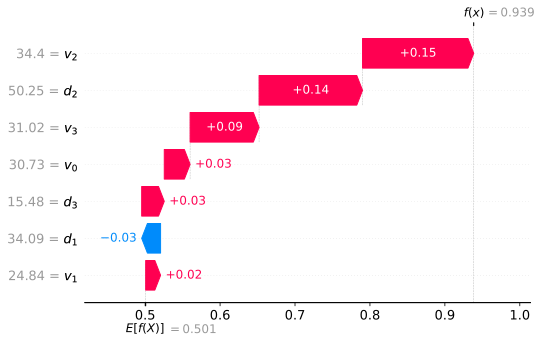

sample number: 2 
  feature value: [ 36.37  34.16  31.8   35.12  28.77  13.6  152.84] 
 EIDG value: [ 0.11625081  0.16163187  0.11372766  0.10646145  0.03353576 -0.10939895
  0.07475346]


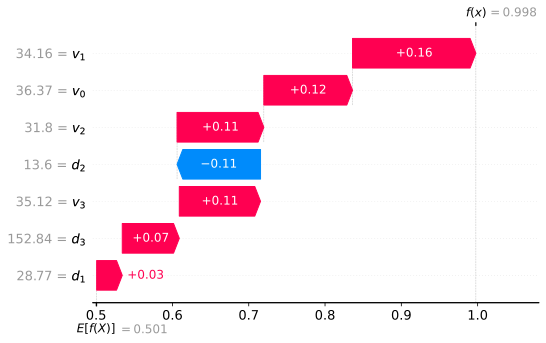

sample number: 3 
  feature value: [ 33.9   22.54  33.62  37.96 101.26  47.92 130.25] 
 EIDG value: [ 0.02990672 -0.34266284  0.00819295 -0.358713   -0.17628658  0.17243636
  0.12014592]


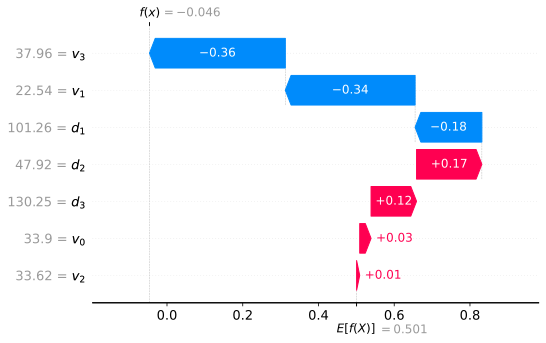

sample number: 4 
  feature value: [33.19 25.88 36.03 33.56 97.96 39.54 39.73] 
 EIDG value: [ 0.04077865  0.05486523  0.06273369  0.04753435 -0.01562202  0.24269024
  0.14637195]


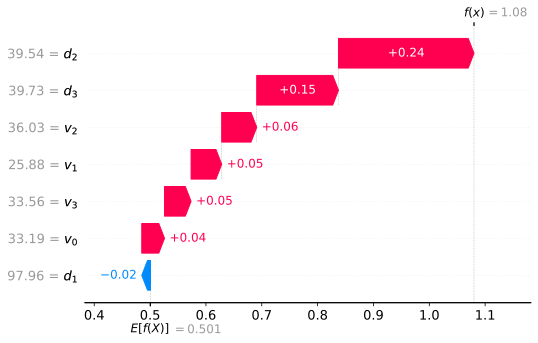

sample number: 5 
  feature value: [27.65 23.84 30.93 29.27 58.22 40.78  7.59] 
 EIDG value: [-0.07163841 -0.39036712  0.2661439   0.15336679 -0.04703088  0.12434164
  0.13566694]


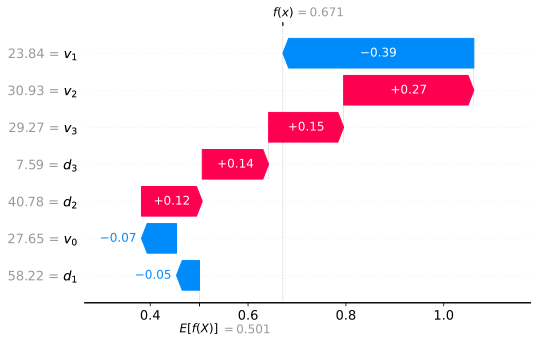

sample number: 6 
  feature value: [ 27.43  35.3   23.91  30.75  52.65  61.09 173.07] 
 EIDG value: [ 0.03375106  0.06876305  0.07569175  0.1348698  -0.03042432  0.13210961
  0.11573946]


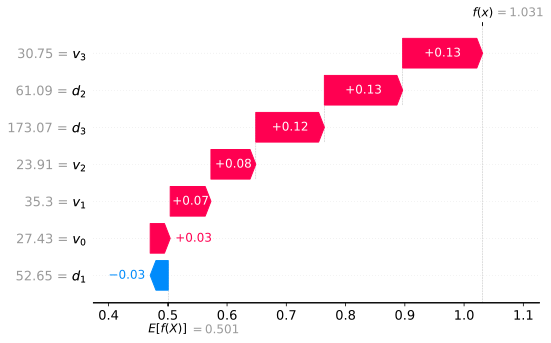

sample number: 7 
  feature value: [ 32.78  37.22  34.88  23.06  26.48 124.74  10.57] 
 EIDG value: [-0.029875    0.05891963  0.10167618 -0.5529554  -0.04171043  0.17800859
  0.14617953]


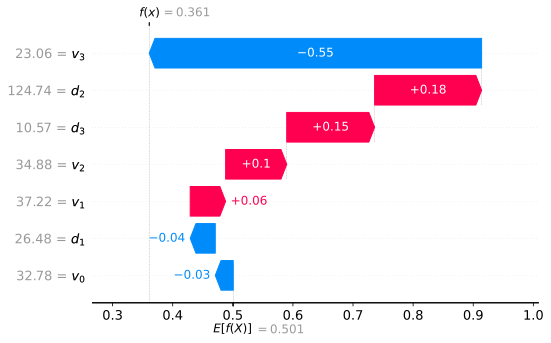

sample number: 8 
  feature value: [26.75 24.35 36.85 32.94 15.87 84.76  9.09] 
 EIDG value: [-0.11546379 -0.42931056 -0.01908795  0.03588337 -0.01490294 -0.05512829
  0.07131826]


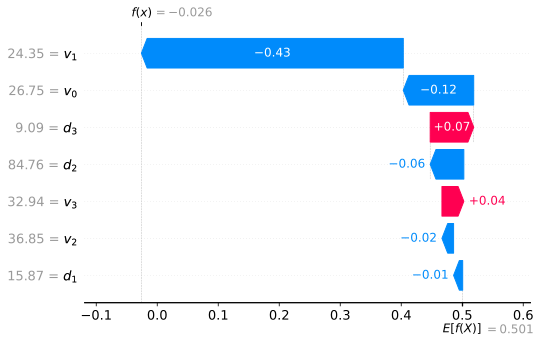

sample number: 9 
  feature value: [ 35.7   28.26  24.62  24.68 217.62  62.92  15.9 ] 
 EIDG value: [-0.17398427  0.13623922 -0.09310549  0.13696219 -0.28473496 -0.02887349
 -0.12079529]


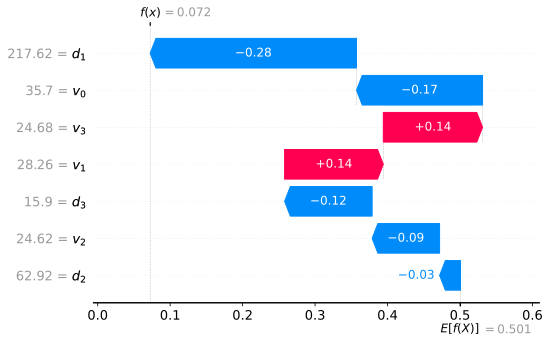

sample number: 10 
  feature value: [ 39.94  41.68  31.11  30.96 353.5    9.22  17.85] 
 EIDG value: [ 0.04490691 -0.35482603  0.06510413  0.03840447  0.06008803 -0.02457858
  0.00287997]


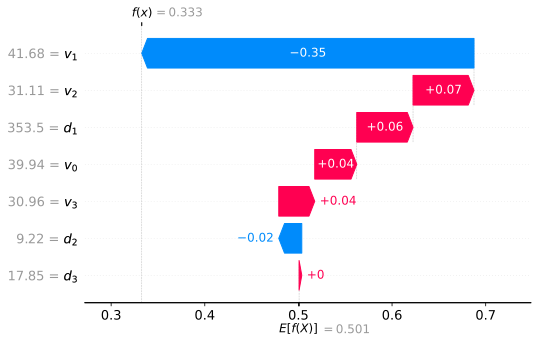

sample number: 11 
  feature value: [ 31.22  30.14  24.49  21.78  44.89  57.87 102.81] 
 EIDG value: [-0.0497568   0.09967574 -0.1310586  -0.50674695 -0.00370062  0.04702747
  0.06072239]


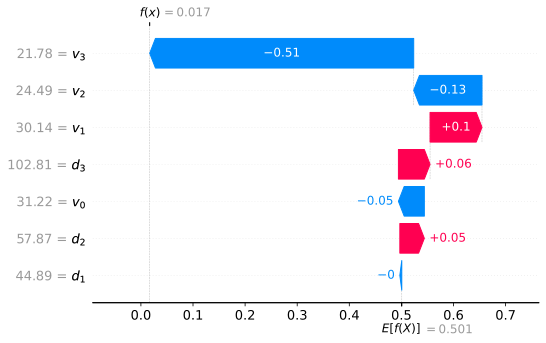

sample number: 12 
  feature value: [23.78 23.71 30.16 32.67 15.01 13.28 31.57] 
 EIDG value: [-0.12907726 -0.44354552 -0.15507632  0.08378252  0.08915997 -0.06484357
  0.06944071]


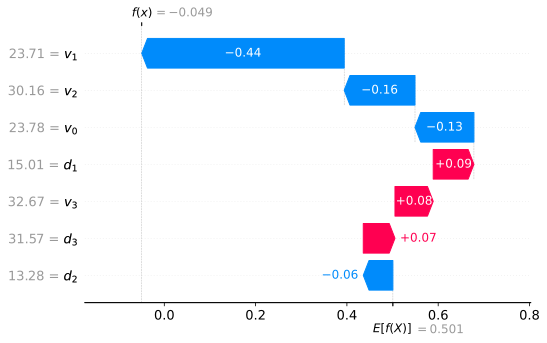

sample number: 13 
  feature value: [ 31.75  33.05  28.21  31.62 107.35  42.15 129.55] 
 EIDG value: [ 0.00797342  0.09271415  0.17257656  0.06470785 -0.06059501  0.02752208
  0.12911715]


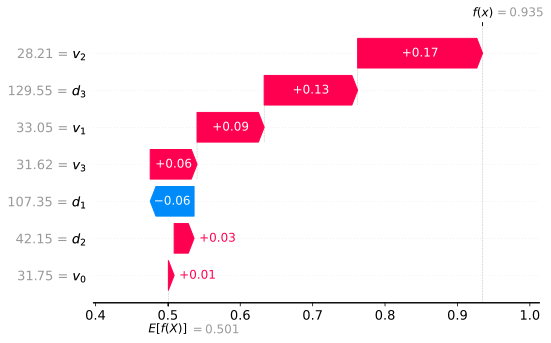

sample number: 14 
  feature value: [22.72 23.27 38.13 35.04 24.18 41.89 47.11] 
 EIDG value: [-0.09423351 -0.5489542  -0.10097378  0.01020539 -0.02438762  0.13458166
  0.03967806]


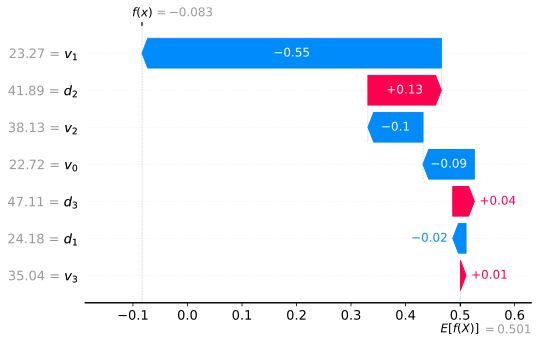

sample number: 15 
  feature value: [22.91 23.2  37.61 35.03 23.56 68.84 25.3 ] 
 EIDG value: [-0.12256271 -0.3875521  -0.20507465  0.09385534 -0.06245387  0.09015372
  0.06781486]


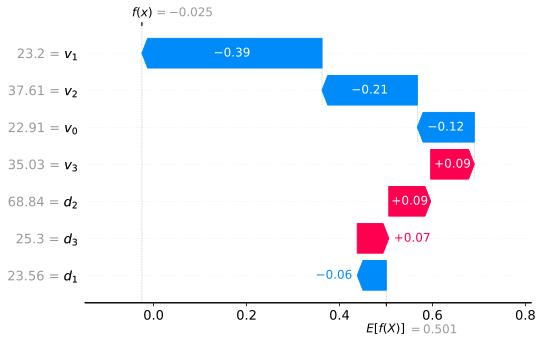

sample number: 16 
  feature value: [34.17 29.04 39.1  38.2  31.55 63.96 76.51] 
 EIDG value: [ 0.06819062  0.00952585  0.10137908 -0.01277852 -0.00108264  0.25416195
  0.04403178]


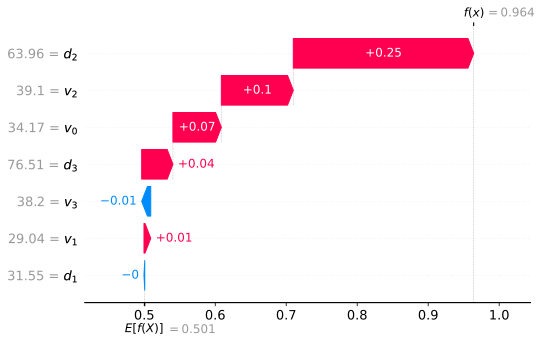

sample number: 17 
  feature value: [33.07 32.8  24.8  24.09 29.01 45.12 31.47] 
 EIDG value: [-0.01728972  0.07641173  0.00078715 -0.6090026  -0.00140927 -0.02273974
  0.03584864]


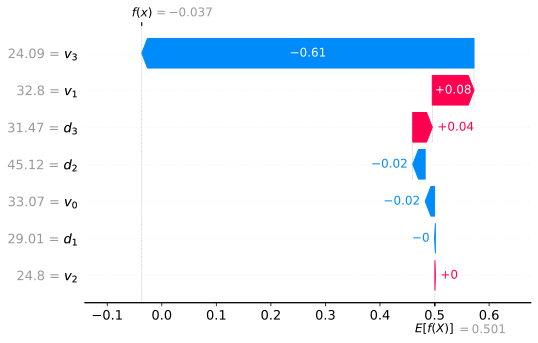

sample number: 18 
  feature value: [34.28 30.05 36.32 35.68 41.06 62.79 45.59] 
 EIDG value: [ 0.03472923 -0.02580494  0.18675028  0.12584442 -0.00473783  0.08065633
  0.05608654]


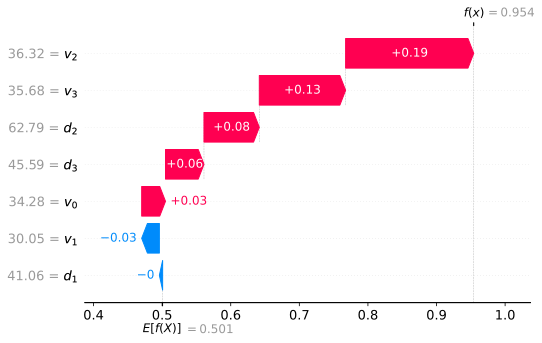

sample number: 19 
  feature value: [24.45 23.67 24.65 25.35 12.16 25.05 32.4 ] 
 EIDG value: [-0.0298064  -0.16342016  0.10013683  0.3836309   0.11055011 -0.03747681
  0.11784589]


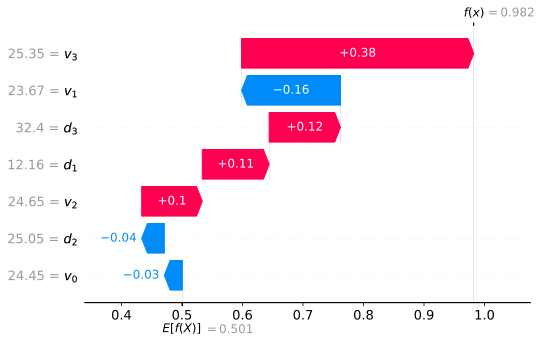

sample number: 20 
  feature value: [ 25.69  21.82  30.18  32.13 102.66  36.87  36.09] 
 EIDG value: [-0.06859398 -0.01197174 -0.25363466  0.04446278 -0.03931106  0.1004895
  0.10959307]


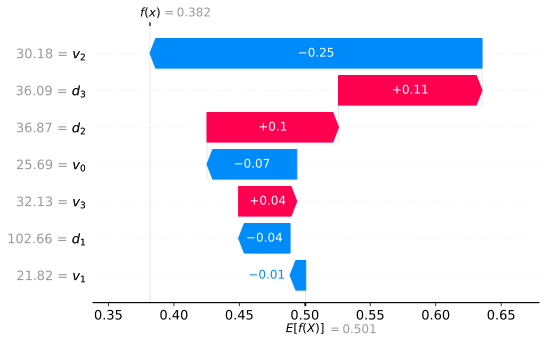

sample number: 21 
  feature value: [ 31.25  32.4   33.5   31.33  60.72  24.63 170.61] 
 EIDG value: [-0.01946556 -0.0677814  -0.09592794  0.05056378 -0.11007947 -0.18203256
  0.08388583]


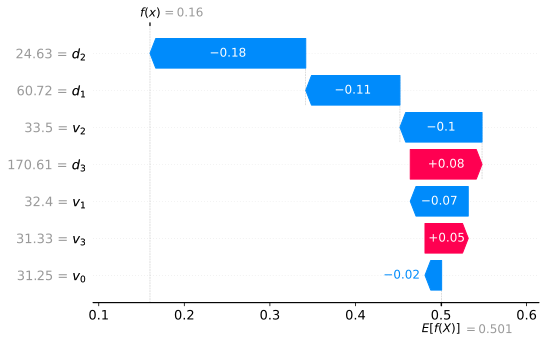

sample number: 22 
  feature value: [ 34.51  35.11  33.67  35.   100.1   10.1  167.23] 
 EIDG value: [ 0.05987539  0.41503435 -0.08191935  0.12301144 -0.04633389 -0.11978725
 -0.03269275]


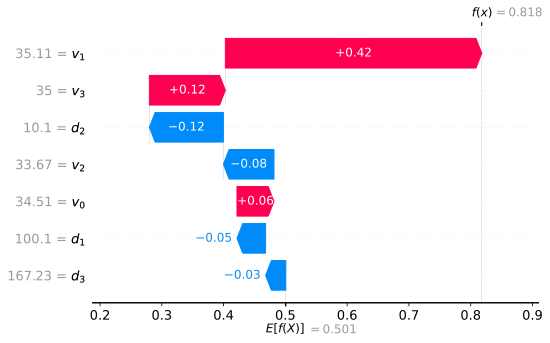

sample number: 23 
  feature value: [21.83 21.53 28.28 24.73 40.34 45.08 28.23] 
 EIDG value: [ 0.11405645 -0.06641001  0.08072443  0.21665208 -0.01877413  0.07223372
  0.13704814]


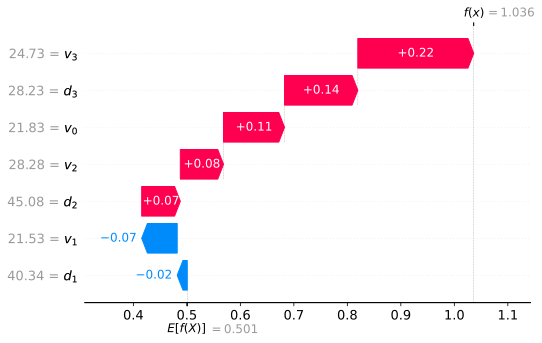

sample number: 24 
  feature value: [27.73 23.54 31.83 30.77 58.35 22.2  69.45] 
 EIDG value: [-0.14084947 -0.18484499  0.10995203  0.01421955 -0.06054616 -0.15895118
 -0.06329346]


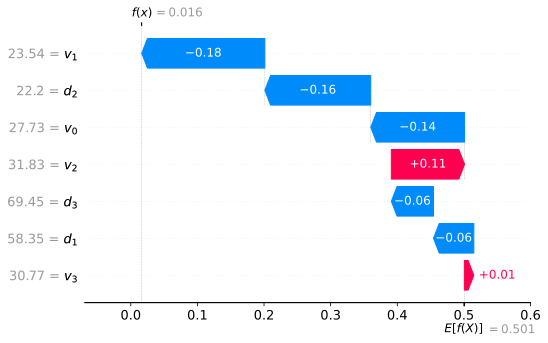

sample number: 25 
  feature value: [ 31.74  32.17  30.02  23.77 186.05  49.32  13.47] 
 EIDG value: [ 0.00443018  0.07004686  0.02324301 -0.4977719  -0.01081728  0.06990518
  0.02200943]


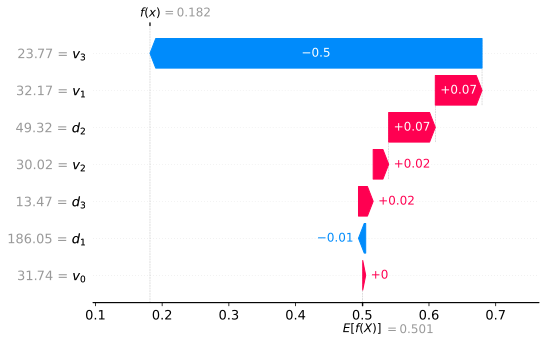

sample number: 26 
  feature value: [23.52 23.21 30.17 32.87 32.06 23.88 24.17] 
 EIDG value: [-0.06854582 -0.2894401  -0.21246316  0.09070991 -0.01370063 -0.07912172
  0.10645412]


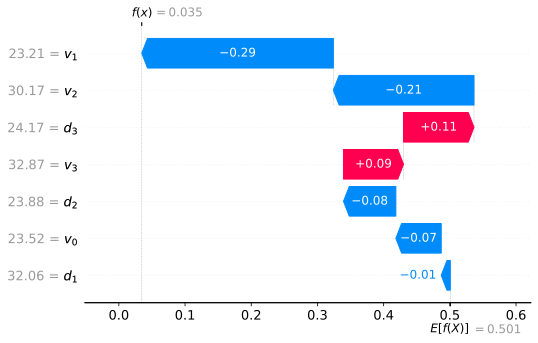

sample number: 27 
  feature value: [33.76 41.4  22.71 33.96 95.33 16.99 89.77] 
 EIDG value: [-0.00418345 -0.14447697 -0.32412574 -0.00053387 -0.04016413 -0.01944643
  0.00965435]


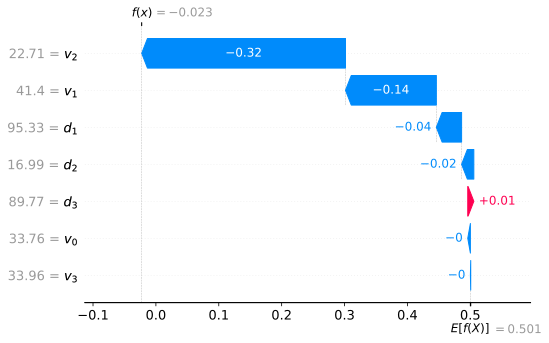

sample number: 28 
  feature value: [16.46 11.76 17.98 15.88 18.07 34.52 14.12] 
 EIDG value: [ 0.03616443  0.03757552  0.12916179  0.22243026  0.03307531 -0.03141918
  0.01748536]


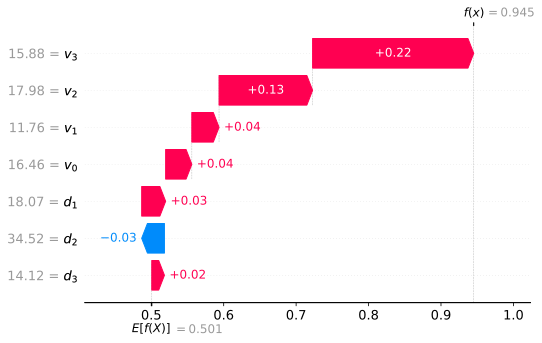

sample number: 29 
  feature value: [25.84 23.84 34.4  38.46 26.17 42.88 34.96] 
 EIDG value: [-0.07394066 -0.31197232  0.03690322 -0.3800841   0.00396336  0.16890484
  0.09156451]


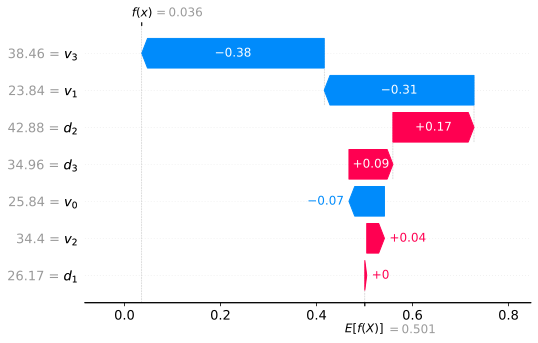

sample number: 30 
  feature value: [ 35.99  34.79  25.53  31.09  34.81  15.97 189.15] 
 EIDG value: [0.00989145 0.08451866 0.12917595 0.12286618 0.01999151 0.00303759
 0.00905751]


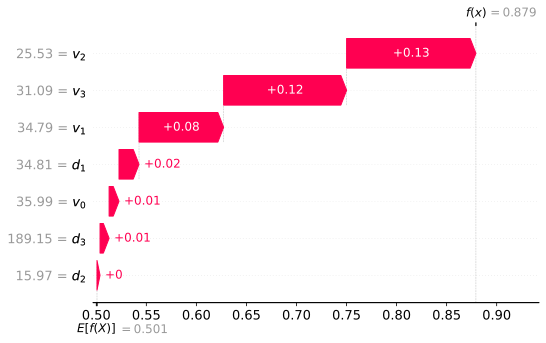

sample number: 31 
  feature value: [ 32.27  34.19  23.27  25.4   41.7   42.24 263.62] 
 EIDG value: [-0.00943866  0.05740372  0.09585548  0.229814   -0.00906334 -0.00595676
  0.22645058]


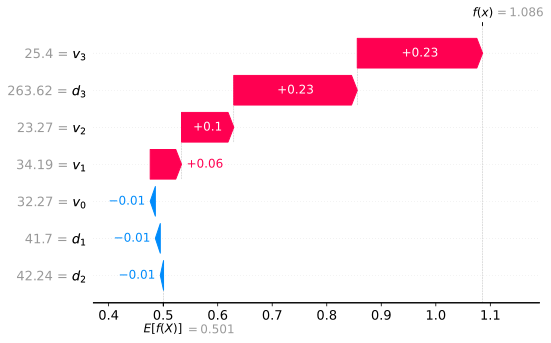

sample number: 32 
  feature value: [ 31.38  34.16  23.14  32.44 138.26  20.37 123.44] 
 EIDG value: [ 0.01127345  0.14444043  0.03202711  0.07982623  0.00480927 -0.00464789
  0.21306911]


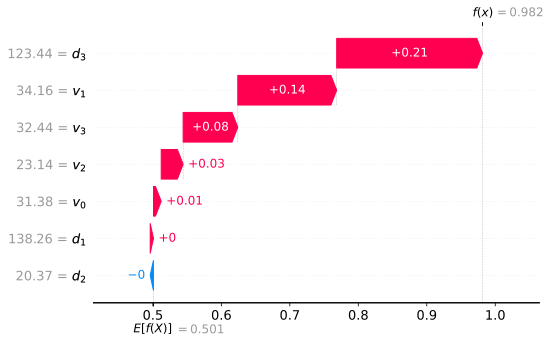

sample number: 33 
  feature value: [22.57 22.06 24.63 24.65 26.84 23.04  6.69] 
 EIDG value: [ 0.19141619 -0.09039391  0.03974822  0.44403303 -0.00485416 -0.04986557
  0.00796555]


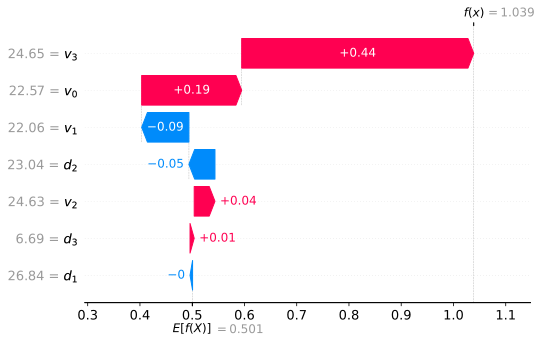

sample number: 34 
  feature value: [29.42 31.75 26.71 28.53 97.52 18.74 79.09] 
 EIDG value: [-0.01050089  0.06565332  0.22564301  0.1774393   0.0254798  -0.02806464
  0.13541952]


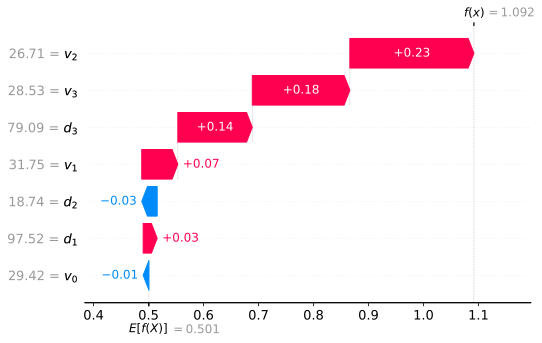

sample number: 35 
  feature value: [  0.51   0.09  21.5   17.85  15.92 111.96  24.3 ] 
 EIDG value: [ 0.17956145  0.17215943 -0.07534201  0.03453856 -0.00371814  0.11019203
  0.03574902]


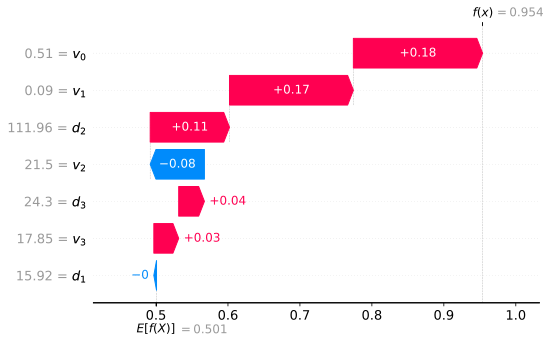

sample number: 36 
  feature value: [ 34.11  35.31  37.52  38.33  46.    26.17 180.57] 
 EIDG value: [-0.0008847   0.13222893 -0.14624265 -0.28126377 -0.01734094 -0.18529628
 -0.02718173]


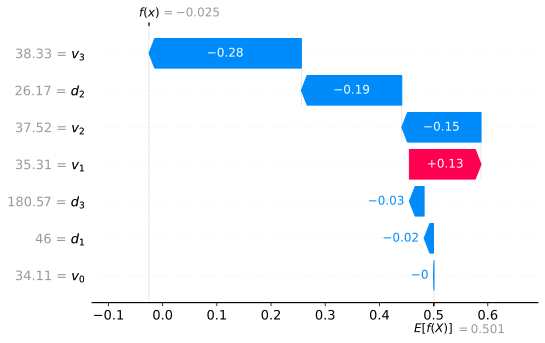

sample number: 37 
  feature value: [35.06 34.39 23.58 34.33 24.82  4.76 67.5 ] 
 EIDG value: [-0.02498393  0.06498022 -0.35932392 -0.01326446 -0.04961668 -0.03543321
  0.04397871]


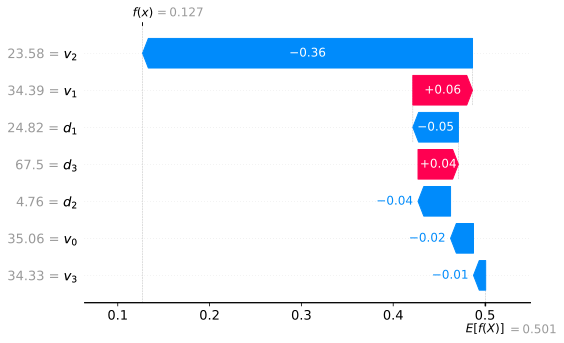

sample number: 38 
  feature value: [29.36 23.99 29.81 30.78 80.08 30.96 60.18] 
 EIDG value: [ 0.04435401 -0.2288046  -0.2513515   0.04719492 -0.04027024  0.01033621
 -0.05070659]


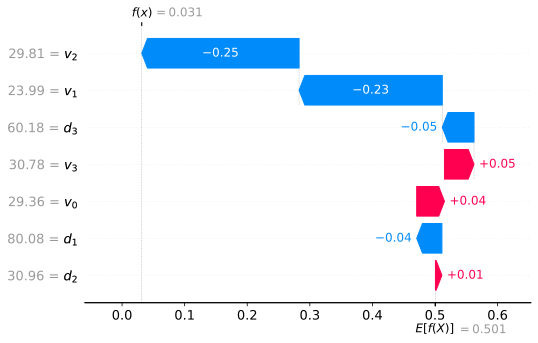

sample number: 39 
  feature value: [ 38.84  37.37  39.43  45.43 104.59  40.46 201.15] 
 EIDG value: [ 0.20296068 -0.03637676 -0.02792699 -0.34855998 -0.07324991  0.09073346
 -0.19193749]


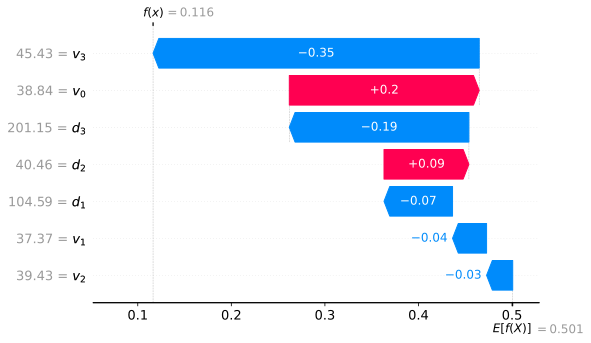

In [14]:
import shap
for i in range(40):
    print("sample number: {} \n  feature value: {} \n EIDG value: {}".format(i, x_test[i], eidg_instance.integrated_gradient_list[1][i]))
    expl = shap.Explanation(values=eidg_instance.integrated_gradient_list[1][i], base_values=eidg_instance.base_value[1], data=x_test[i])
    
    expl.feature_names = feature_name
    # # expl.data = max_q_sample.numpy()[0]
    # expl.data = df.values[0]
    shap.waterfall_plot(expl, show=False)
    
    plt.savefig(f'../figure/local_waterfall_1_{i}.svg', dpi=600, bbox_inches='tight')
    plt.show() 